Each group is (1 x group_cols, N_events x event_cols)
Each flash is (1 x flash_cols, N_groups x group_cols)

So loop over each flash
    slice out all matching groups 
        loop over each group
            slice out all matching events
                yield a dataset reduced to just these parts that correspond to one flash



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from glmtools.io.glm import GLMDataset, fix_event_locations

In [2]:
# filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20152242125152_e20152242125357_c20152242125498.nc'
# filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20171081818480_e20171081818500_c20171081819229.nc'

filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20171161230400_e20171161231000_c20171161231027.nc'
# flash 6567 has 81 groups, 188 events
# 2017-04-26T12:30:56

# filename = '/data/LCFA-production/L2_test_Apr/FGE_LCFA/glm_fge_pnew_201703301520.nc'
# flash 1976 is weird

In [3]:
glm = GLMDataset(filename)
print(glm.dataset.event_energy)
# print(glm.dataset.event_count.encoding)

<xarray.DataArray 'event_energy' (number_of_events: 8148)>
array([  6.051940e-15,   6.051940e-15,   6.051940e-15, ...,   6.051940e-15,
         6.051940e-15,   9.103880e-15])
Coordinates:
    product_time           datetime64[ns] 2017-04-26T12:30:40
    lightning_wavelength   float32 777.4
    group_time_threshold   float32 0.0
    flash_time_threshold   float32 3.33
    lat_field_of_view      float32 0.0
    lon_field_of_view      float32 -89.5
  * number_of_events       (number_of_events) MultiIndex
  - event_parent_group_id  (number_of_events) int64 47020807 47020807 ...
  - event_id               (number_of_events) int64 127071696 127071697 ...
  - event_time_offset      (number_of_events) datetime64[ns] 2017-04-26T12:30:39.892000 ...
  - event_lat              (number_of_events) float64 -5.211 -5.211 -5.138 ...
  - event_lon              (number_of_events) float64 -77.97 -78.05 -78.05 ...
Attributes:
    long_name:      GLM L2+ Lightning Detection: event radiant energy
    standar

<function __main__.do_plot>

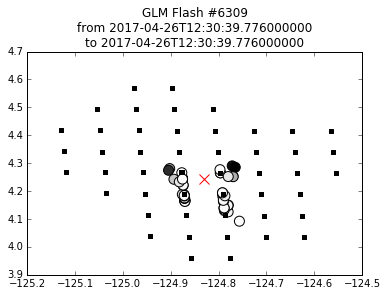

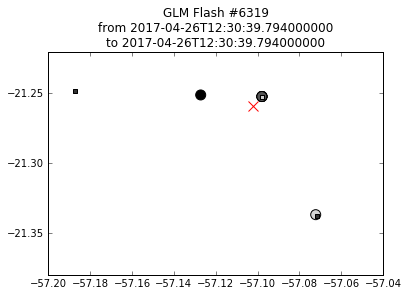

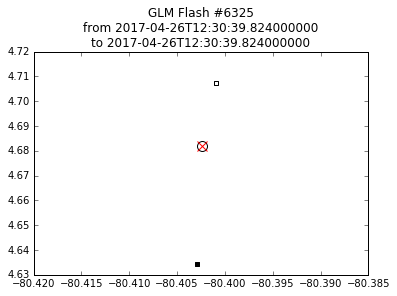

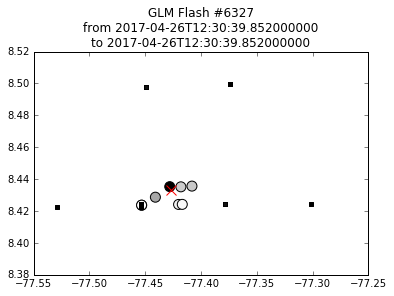

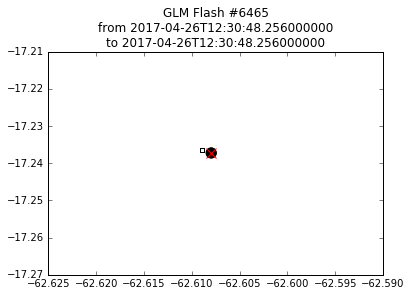

In [5]:
from glmtools.plot.locations import plot_flash

import ipywidgets as widgets
# print(widgets.Widget.widget_types.values())
fl_id_vals = list(glm.dataset.flash_id.data)
fl_id_vals.sort()
flash_slider =  widgets.SelectionSlider(
    description='Flash',
    options=fl_id_vals,
)

# from functools import partial
# glm_plotter = partial(plot_flash, glm) # fails with a __name__ attr not found
def do_plot(flash_id):
    fig = plot_flash(glm, flash_id)
widgets.interact(do_plot, flash_id=flash_slider)

In [7]:
# here is an example of a low-level read with xarray, and dumping data in a pretty way with pandas.
# experimental and not well tested.
some_flash = 16841 
# some_flash = 16468
# d = xr.open_dataset(filename)
singleton_flash_id = 15928

filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20171161230400_e20171161231000_c20171161231027.nc'
some_flash = 6359
max_area_flash = 6472


fov_dim = 'number_of_field_of_view_bounds'
wave_dim = 'number_of_wavelength_bounds'
time_dim = 'number_of_time_bounds'
gr_dim = 'number_of_groups'
ev_dim = 'number_of_events'
fl_dim = 'number_of_flashes'

# import pandas as pd
# d.indexes['number_of_events'] = pd.Int64Index(data=d.event_id.data, name='number_of_events')
# d.indexes['number_of_groups'] = pd.Int64Index(data=d.group_id.data, name='number_of_groups')
# d.indexes['number_of_flashes'] = pd.Int64Index(data=d.flash_id.data, name='number_of_flashes')

# empty = slice(0, 0)
# print(d[{fov_dim:empty, time_dim:empty, wave_dim:empty}])

# d = d[{'number_of_events':slice(0,0), 'number_of_groups':slice(0,0), 'number_of_flashes':slice(None)}]
# print(d)

egf = glm.dataset#.group_id[glm.dataset.group_id==20208]

egf_grgb=egf.groupby('group_parent_flash_id')

gr_idx = egf_grgb.groups[some_flash]
this_flash = egf[{'number_of_groups':gr_idx}]
print(this_flash)

<xarray.Dataset>
Dimensions:                                 (number_of_events: 8148, number_of_field_of_view_bounds: 2, number_of_flashes: 299, number_of_groups: 10, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
Coordinates:
    product_time                            datetime64[ns] 2017-04-26T12:30:40
    lightning_wavelength                    float64 777.4
    group_time_threshold                    float64 0.0
    flash_time_threshold                    float64 3.33
    lat_field_of_view                       float64 0.0
    lon_field_of_view                       float64 -89.5
  * number_of_events                        (number_of_events) MultiIndex
  - event_parent_group_id                   (number_of_events) int64 47020807 ...
  - event_id                                (number_of_events) int64 127071696 ...
  - event_time_offset                       (number_of_events) datetime64[ns] 2017-04-26T12:30:39.892000 ...
  - event_lat                               (numbe

In [6]:
# This is an example of a lower-level read, directly using NetCDF4
# instead of xarray. xarray does some additional metadata processing
# and provides groupby, etc., which is especially helpful when 
# querying clustered datasets with common keys linking data tables.

# For '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20152242125152_e20152242125357_c20152242125498.nc'
singleton_flash_id = 15928
singleton_group_id = 13280582
singleton_event_id = 13521629



# demonstrate it's not a problem with xarray
import netCDF4
nc = netCDF4.Dataset(filename)
this_ev = nc.variables['event_id'][:] == singleton_event_id
this_gr = nc.variables['group_id'][:] == singleton_group_id
this_fl = nc.variables['flash_id'][:] == singleton_flash_id

ev_id = nc.variables['event_id'][this_ev]
gr_id = nc.variables['group_id'][this_gr]
fl_id = nc.variables['flash_id'][this_fl]

ev_time_offset = nc.variables['event_time_offset']
print(ev_time_offset)
ev_times = netCDF4.num2date(ev_time_offset[:], units=ev_time_offset.units)
print ev_times[0:5]

ev_parent = nc.variables['event_parent_group_id'][this_ev]
gr_parent = nc.variables['group_parent_flash_id'][this_gr]

ev_lat = nc.variables['event_lat'][this_ev]
gr_lat = nc.variables['group_lat'][this_gr]
fl_lat = nc.variables['flash_lat'][this_fl]

# print(ev_id)
# print(ev_parent)
# print(gr_id)
# print(gr_parent)
# print(fl_id)
# print(ev_lat)
# print(gr_lat)
# print(fl_lat)

# print(nc)

# Dimensions:                                 (number_of_events: 1, number_of_field_of_view_bounds: 2, number_of_flashes: 1, number_of_groups: 1, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
# Coordinates:
#     event_id                                (number_of_events) int32 13521629
#     event_time_offset                       (number_of_events) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     event_lat                               (number_of_events) float64 -47.5
#     event_lon                               (number_of_events) float64 -130.7
#     event_parent_group_id                   (number_of_events) int32 13280582
#     group_id                                (number_of_groups) int32 13280582
#     group_time_offset                       (number_of_groups) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     group_lat                               (number_of_groups) float32 3.81698
#     group_lon                               (number_of_groups) float32 -126.438
#     group_parent_flash_id                   (number_of_groups) int16 15928
#     flash_id                                (number_of_flashes) int16 15928
#     flash_time_offset_of_first_event        (number_of_flashes) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     flash_time_offset_of_last_event         (number_of_flashes) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     flash_lat                               (number_of_flashes) float32 3.81698
#     flash_lon                               (number_of_flashes) float32 -126.438
#     product_time                            datetime64[ns] 2015-08-12T21:25:15.260505 ...
#     lightning_wavelength                    float64 777.4
#     group_time_threshold                    float64 0.0
#     flash_time_threshold                    float64 3.33
#     lat_field_of_view                       float64 0.0
#     lon_field_of_view                       float64 -75.0
#   * number_of_events                        (number_of_events) int64 0
#   * number_of_groups                        (number_of_groups) int64 0
#   * number_of_flashes                       (number_of_flashes) int64 0
#   * number_of_time_bounds                   (number_of_time_bounds) int64 0 1
#   * number_of_wavelength_bounds             (number_of_wavelength_bounds) int64 0 ...
#   * number_of_field_of_view_bounds          (number_of_field_of_view_bounds) int64 0 ...


<type 'netCDF4._netCDF4.Variable'>
int16 event_time_offset(number_of_events)
    long_name: GLM L2+ Lightning Detection: event’s time of occurrence
    standard_name: time
    scale_factor: 2.0
    add_offset: 0.0
    units: milliseconds since 2017-04-18 18:18:48.046
    axis: T
unlimited dimensions: number_of_events
current shape = (390,)
filling on, default _FillValue of -32767 used

[datetime.datetime(2017, 4, 18, 18, 18, 48, 188000)
 datetime.datetime(2017, 4, 18, 18, 18, 48, 194000)
 datetime.datetime(2017, 4, 18, 18, 18, 48, 196000)
 datetime.datetime(2017, 4, 18, 18, 18, 48, 202000)
 datetime.datetime(2017, 4, 18, 18, 18, 48, 204000)]


<class 'netCDF4._netCDF4.Variable'>
int16 event_lon(number_of_events)
    long_name: GLM L2+ Lightning Detection: event longitude coordinate
    standard_name: longitude
    _Unsigned: true
    scale_factor: 0.00203128
    add_offset: -156.06
    units: degrees_east
    axis: X
unlimited dimensions: number_of_events
current shape = (8148,)
filling on, default _FillValue of -32767 used

<class 'netCDF4._netCDF4.Variable'>
int16 event_lat(number_of_events)
    long_name: GLM L2+ Lightning Detection: event latitude coordinate
    standard_name: latitude
    _Unsigned: true
    scale_factor: 0.00203128
    add_offset: -66.56
    units: degrees_north
    axis: Y
unlimited dimensions: number_of_events
current shape = (8148,)
filling on, default _FillValue of -32767 used



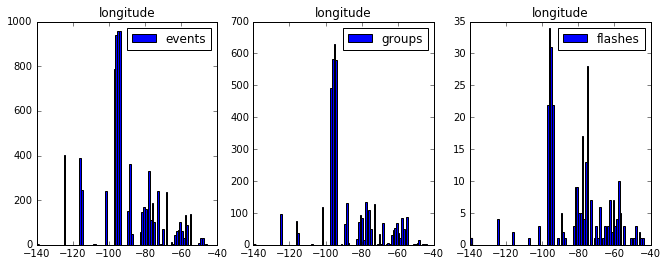

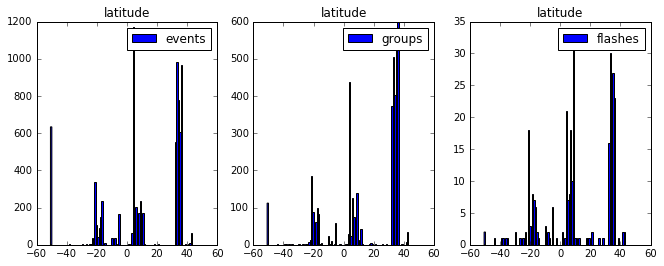

In [8]:
filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20171161230400_e20171161231000_c20171161231027.nc'
some_flash = 6359

import netCDF4
nc = netCDF4.Dataset(filename)

# from PUG spec
lon_fov = (-156.06, -22.94)
dlon_fov = lon_fov[1]-lon_fov[0]
lat_fov = (-66.56, 66.56)
# zeroth element of the above are the add_offset values in the spec, and in the data file

group_lons = nc.variables['group_lon'][:]
group_lats = nc.variables['group_lat'][:]

flash_lons = nc.variables['flash_lon'][:]
flash_lats = nc.variables['flash_lat'][:]

event_lons = nc.variables['event_lon']
event_lats = nc.variables['event_lat']

event_lons.set_auto_scale(False)
event_lats.set_auto_scale(False)

# event_lats_fixed2, event_lons_fixed2 = fix_event_locations(event_lats, event_lons)

# unsigned = 2**16
# event_lons = event_lons[:].astype('int32')
# event_lons[event_lons < 0] += unsigned
# event_lats = event_lats[:].astype('int32')
# event_lats[event_lats < 0] += unsigned

# Same thing as above
event_lons_fixed = event_lons[:].view('<u2')
event_lats_fixed = event_lats[:].view('<u2')

# Rescale
scale_factor = 0.00203128 # from file and spec; same for both
event_lons_fixed = (event_lons_fixed)*scale_factor+lon_fov[0]
event_lats_fixed = (event_lats_fixed)*scale_factor+lat_fov[0]

plt.figure(figsize=(11,4))
plt.subplot(131)
hist_plot=plt.hist(event_lons_fixed, bins=100, label='events')
plt.title('longitude')
plt.legend()

plt.subplot(132)
hist_plot=plt.hist(group_lons, bins=100, label='groups')
plt.title('longitude')
plt.legend()

plt.subplot(133)
hist_plot=plt.hist(flash_lons, bins=100, label='flashes')
plt.title('longitude')
plt.legend()

ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.figure(figsize=(11,4))
plt.subplot(131)
hist_plot=plt.hist(event_lats_fixed, bins=100, label='events')
plt.title('latitude')
plt.legend()

plt.subplot(132)
hist_plot=plt.hist(group_lats, bins=100, label='groups')
plt.title('latitude')
plt.legend()

plt.subplot(133)
hist_plot=plt.hist(flash_lats, bins=100, label='flashes')
plt.title('latitude')
plt.legend()

ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

print(event_lons)
print(event_lats)



In [23]:
nc['event_parent_group_id']

<type 'netCDF4._netCDF4.Variable'>
int32 event_parent_group_id(number_of_events)
    long_name: product-unique lightning group identifier for one or more events
    _Unsigned: true
    units: 1
unlimited dimensions: number_of_events
current shape = (8148,)
filling on, default _FillValue of -2147483647 used

In [31]:
# From earlier development - not needed.

def member_mask_for_cluster(dataset, cluster_id_column_name, cluster_ids):
    """ Given cluster_ids which correspond to values in 
        dataset.cluster_id_column_name, .
        """
    cluster_id_col = getattr(dataset, cluster_id_column_name)
    
    mask = np.zeros(cluster_id_col.shape[0], dtype=bool)
    for cluster_id in cluster_ids:
        mask |= (cluster_id == cluster_id_col)
    return mask

def gen_flashes(dataset):
    # need to set index on flash_id, group_id, and event_id coordinates.
    split_gr = d.groupby('group_parent_flash_id')
    # split_gr gives us a mapping from a flash index to the group indices
    # corresponding to that flash. Index refers to columns marked with 
    # an "*" in print(dataset)
    
    split_ev = d.groupby('event_parent_group_id')
    
    # careful: xarray uses groups to refer to the result of the groupby,
    # and does not refer here to GLM groups.
    for fl_idx, gr_idxs in split_gr.groups.items():
        # now we can use the flash index and group indices directly
        # need to pull out a combined set of event indices corresponding
        # to all groups
        ev_iter = (split_ev.groups[gr_id] for gr_id in gr_idxs)
        ev_idxs = list(itertools.chain.from_iterable(ev_iter))
        this_flash = d[{'number_of_events':ev_idxs, 'number_of_groups':gr_idxs, 'number_of_flashes':fl_idx}]

        yield this_flash

def get_flash(self, flash_id):
    good_gr = (self.group_parent_flash_id == flash_id)
    group_ids = self.group_id[good_gr]
    group_areas = self.group_area[good_gr]
    for group_area, group_id in zip(group_areas, group_ids):
        good_ev = (self.event_parent_group_id == group_id)
        pixel_energies = d.event_energy[good_ev]
        print(pixel_energies, type(group_area))
# get_flash(d, some_flash)

for fl in gen_flashes(d): print fl

# can we subset everything along the number_of_events dimension?

KeyError: 791